In [1]:
import pandas_datareader.data as web
# import sklearn.mixture as mix
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn import hmm
import datetime


TMV AND TIME

In [2]:


arr=[]
for j in np.arange(0.01,1,1):
    df1 = web.DataReader(['sp500'], 'fred', start = '2021-09-30',end='2022-09-29')

    df2= web.DataReader(['VIXCLS'], 'fred', start = '2021-09-30',end='2022-09-29')
    start_date = datetime.datetime(2021, 9, 1)
    end_date=datetime.datetime(2022, 9, 29)
    df3= web.DataReader('TSLA','stooq', start = start_date,end=end_date)
    df4=pd.read_csv("/Users/devanshjoshi/Downloads/data_final.csv")
    df5=df4.loc[:,['Date','Scaled_compound']]
    df_=pd.concat([df1,df2,df3],axis=1)
    df_.drop(['Open','High','Low','Volume'],axis=1,inplace=True)
    df_=df_.dropna()
    df_=df_.reset_index()
    df_.rename(columns = {'index':'Date'}, inplace = True)
    df_['Date']=pd.to_datetime(df_['Date'])
    df5['Date']=pd.to_datetime(df5['Date'])
    df= pd.merge(df_,df5, on='Date', how='inner')

    x=df['Close']
    x=x.to_numpy()


    high=x[0]
    low=x[0]
    returns=[]
    tmv=[]
    threshold=j
    arr_time=[]
    ## 0.056 best for ret, vol, 66 ret and 22 ret
    ## 0.05 quite stable for new_data but graph fluctuates
    ## 0.08 not stable but predictions are accurate and graph stable-ish
    time=0
    up=0
    down=0
    dc=0
    time_high=0
    time_low=0
    first_time=0
    for i in range(1,len(x)):
        time=time+1
        if(up==0 and down==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
                first_time=time
            elif(x[i]<=(1-threshold)*low):
                down=1
                up=0
                low=x[i]
                time_low=time
                first_time=time
            else:
                pass
        elif(up==1 and dc==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
                dc=1
                down=1
                up=0
                low=x[i]
                time_low=time
            else:
                pass
        elif(down==1 and dc==0):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
                dc=1
                down=0
                up=1
                high=x[i]
                time_high=time
            else:
                pass
        elif(up==1 and dc==1):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
    #             r=[(high-low)/(low*time)]*time /////WORKS

                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(low*t_bw_trend))]*t_bw_trend
                tm=[abs((high-low)/(low*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                low=x[i]
                time_low=time
                up=0
                down=1
            else:
                pass
        elif(down==1 and dc==1):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
    #             r=[abs((low-high)/(high*time))]*time ////WORKS
                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(high*t_bw_trend))]*t_bw_trend
                tm=[abs((low-high)/(high*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                high=x[i]
                time_high=time
                up=1
                down=0
            else:
                pass
        else:
            pass





    buffer_beginning=[returns[0]]*first_time
    returns.extend(buffer_beginning)
    buffer_end=[returns[len(returns)-1]]*(time-(len(returns)-1))
    returns.extend(buffer_end)

    returns=np.array(returns)

    buffer_beginning=[tmv[0]]*first_time
    tmv.extend(buffer_beginning)
    buffer_end=[tmv[len(tmv)-1]]*(time-(len(tmv)-1))
    tmv.extend(buffer_end)

    tmv=np.array(tmv)

    buffer_beginning=[arr_time[0]]*first_time
    arr_time.extend(buffer_beginning)
    buffer_end=[arr_time[len(arr_time)-1]]*(time-(len(arr_time)-1))
    arr_time.extend(buffer_end)

    arr_time=np.array(arr_time)

    for i in range(len(returns)):
        returns[i]=math.log(returns[i])
    # print(" log Returns")
    # plt.plot(dates,returns)
    df['Returns']=returns
    df['TMV']=tmv
    df['Time']=arr_time



    df['Regime']=" "
    df["D_ret"]=' '
    df["D_ret"]=df["Close"].pct_change()
    df["22_ret"]=df["Close"].pct_change(22)
    df["66_ret"]=df["Close"].pct_change(66)
    # X_train["Vol"]=X_train["D_ret"]
    df["Vol"]=df["Close"].pct_change().rolling(22).std()
    df=df.dropna()


#     X=df.loc[:,["PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 amaze
#     X=df.loc[:,["Returns","22_ret","66_ret","VIX"]] ##0.01 or 0.04
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D"]] ##0.03 or 0.08
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 or 0.09999
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret"]] ##0.01 or 0.09999 best
    X=df.loc[:,["Returns","sp500","VIXCLS","22_ret","66_ret","Vol"]] ##0.01 or 0.09

    
    scores = list()
    models = list()
    for n_components in range(1, 5):
        for idx in range(1):
            model = hmm.GaussianHMM(n_components=n_components, random_state=idx)
            model.fit(X)
            models.append(model)
            scores.append(model.score(X))
            print("No of hidden states:",n_components)
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
    model = models[np.argmax(scores)]
    df["Regime"]=model.predict(X)

    tmv_arr=df["TMV"].to_numpy()
    maxtmv=np.max(tmv_arr)
    mintmv=np.min(tmv_arr)
    time_arr=df["Time"].to_numpy()
    maxtime=np.max(time_arr)
    mintime=np.min(time_arr)



    arr1=df[["Regime", "TMV"]].groupby("Regime").mean()
    arr2=df[["Regime", "Time"]].groupby("Regime").mean()
    x_axis=arr1["TMV"]
    x_axis=x_axis.to_numpy()
    y_axis=arr2["Time"]
    y_axis=y_axis.to_numpy()
    for i in range(0,len(x_axis)):
        x_axis[i]=x_axis[i]-mintmv/(maxtmv-mintmv)
        y_axis[i]=y_axis[i]-mintime/(maxtime-mintime)
    
    arr.append((x_axis,y_axis))
# print(arr)

# plt.scatter(x_axis,y_axis,color=['red','green','blue','black'])





No of hidden states: 1
Converged: True		Score: -1305.5117338304065
No of hidden states: 2
Converged: True		Score: -1123.281130885256
No of hidden states: 3
Converged: True		Score: -970.3277385037806
No of hidden states: 4
Converged: True		Score: -927.4081884326172


In [3]:
# mean=df[["Regime", "D_ret"]].groupby("Regime").mean()
# std=df[["Regime", "D_ret"]].groupby("Regime").std()
# print(df[["Regime", "D_ret"]].groupby("Regime").mean())
# print(df[["Regime", "D_ret"]].groupby("Regime").std())


Threshold is: 0.01


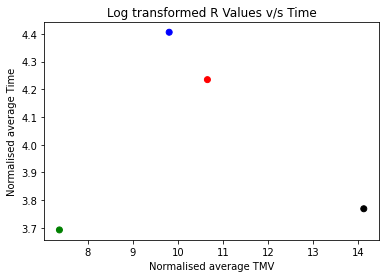

In [4]:
array=[i for i in np.arange(0.01,0.11,0.01)]
for i in range(0,len(arr)):
    print("Threshold is:",array[i])
    plt.figure()
    plt.title('Log transformed R Values v/s Time')
    plt.xlabel('Normalised average TMV')
    plt.ylabel('Normalised average Time')
    plt.scatter(arr[i][0],arr[i][1],color=['red','green','blue','black'])
plt.show()

In [5]:
# array=[i for i in np.arange(0.01,0.01,0.01)]
# for i in range(0,len(arr)):
    
#     plt.figure()
# #     print("Threshold is:",array[i])
#     plt.scatter(mean,std,color=['red','green','blue','black'])
#     plt.title('Mean vs Standard Deviation of the 4 regimes')
#     plt.xlabel('Mean')
#     plt.ylabel('Standard Deviation')
# plt.show()

MEAN AND STD

In [6]:
import pandas_datareader.data as web
# import sklearn.mixture as mix
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn import hmm

arr=[]
scores = list()
models = list()
for j in np.arange(0.01,0.011,0.01):
    df1 = web.DataReader(['sp500'], 'fred', start = '2021-09-30',end='2022-09-29')

    df2= web.DataReader(['VIXCLS'], 'fred', start = '2021-09-30',end='2022-09-29')
    start_date = datetime.datetime(2021, 9, 1)
    end_date=datetime.datetime(2022, 9, 29)
    df3= web.DataReader('TSLA','stooq', start = start_date,end=end_date)
    df4=pd.read_csv("/Users/devanshjoshi/Downloads/data_final.csv")
    df5=df4.loc[:,['Date','Scaled_compound']]
    df_=pd.concat([df1,df2,df3],axis=1)
    df_.drop(['Open','High','Low','Volume'],axis=1,inplace=True)
    df_=df_.dropna()
    df_=df_.reset_index()
    df_.rename(columns = {'index':'Date'}, inplace = True)
    df_['Date']=pd.to_datetime(df_['Date'])
    df5['Date']=pd.to_datetime(df5['Date'])
    df= pd.merge(df_,df5, on='Date', how='inner')

    x=df['Close']
    x=x.to_numpy()


    high=x[0]
    low=x[0]
    returns=[]
    tmv=[]
    threshold=j
    arr_time=[]
    ## 0.056 best for ret, vol, 66 ret and 22 ret
    ## 0.05 quite stable for new_data but graph fluctuates
    ## 0.08 not stable but predictions are accurate and graph stable-ish
    time=0
    up=0
    down=0
    dc=0
    time_high=0
    time_low=0
    first_time=0
    for i in range(1,len(x)):
        time=time+1
        if(up==0 and down==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
                first_time=time
            elif(x[i]<=(1-threshold)*low):
                down=1
                up=0
                low=x[i]
                time_low=time
                first_time=time
            else:
                pass
        elif(up==1 and dc==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
                dc=1
                down=1
                up=0
                low=x[i]
                time_low=time
            else:
                pass
        elif(down==1 and dc==0):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
                dc=1
                down=0
                up=1
                high=x[i]
                time_high=time
            else:
                pass
        elif(up==1 and dc==1):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
    #             r=[(high-low)/(low*time)]*time /////WORKS

                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(low*t_bw_trend))]*t_bw_trend
                tm=[abs((high-low)/(low*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                low=x[i]
                time_low=time
                up=0
                down=1
            else:
                pass
        elif(down==1 and dc==1):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
    #             r=[abs((low-high)/(high*time))]*time ////WORKS
                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(high*t_bw_trend))]*t_bw_trend
                tm=[abs((low-high)/(high*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                high=x[i]
                time_high=time
                up=1
                down=0
            else:
                pass
        else:
            pass





    buffer_beginning=[returns[0]]*first_time
    returns.extend(buffer_beginning)
    buffer_end=[returns[len(returns)-1]]*(time-(len(returns)-1))
    returns.extend(buffer_end)

    returns=np.array(returns)

    buffer_beginning=[tmv[0]]*first_time
    tmv.extend(buffer_beginning)
    buffer_end=[tmv[len(tmv)-1]]*(time-(len(tmv)-1))
    tmv.extend(buffer_end)

    tmv=np.array(tmv)

    buffer_beginning=[arr_time[0]]*first_time
    arr_time.extend(buffer_beginning)
    buffer_end=[arr_time[len(arr_time)-1]]*(time-(len(arr_time)-1))
    arr_time.extend(buffer_end)

    arr_time=np.array(arr_time)

    for i in range(len(returns)):
        returns[i]=math.log(returns[i])
    # print(" log Returns")
    # plt.plot(dates,returns)
    df['Returns']=returns
    df['TMV']=tmv
    df['Time']=arr_time



    df['Regime']=" "
    df["D_ret"]=' '
    df["D_ret"]=df["Close"].pct_change()
    df["22_ret"]=df["Close"].pct_change(22)
    df["66_ret"]=df["Close"].pct_change(66)
    # X_train["Vol"]=X_train["D_ret"]
    df["Vol"]=df["Close"].pct_change().rolling(22).std()
    df=df.dropna()
    df.head()

#     X=df.loc[:,["Returns","22_ret","66_ret"]] ##0.01 amaze
#     X=df.loc[:,["Returns","22_ret","66_ret","VIX"]] ##0.01 or 0.04
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D"]] ##0.03 or 0.08
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 or 0.09999
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret"]] ##0.01 or 0.09999 best
    X=df.loc[:,["Returns","sp500","VIXCLS","22_ret","66_ret","Vol"]] ##0.01 or 0.09
            
    #         print(f'Converged: {model.monitor_.converged}\t\t'
    #               f'Score: {scores[-1]}')
    model = hmm.GaussianHMM(n_components=4, random_state=1)
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    
    df["Regime"]=model.predict(X)
    
    df["Regime"]=df['Regime'].shift(1)
    df["Daily"]=' '
    df["Daily"]=df["Close"].pct_change()
    MEAN=df[["Regime", "Daily"]].groupby("Regime").mean()
    STD=df[["Regime", "Daily"]].groupby("Regime").std()

#     tmv_arr=df["TMV"].to_numpy()
#     maxtmv=np.max(tmv_arr)
#     mintmv=np.min(tmv_arr)
#     time_arr=df["Time"].to_numpy()
#     maxtime=np.max(time_arr)
#     mintime=np.min(time_arr)



#     arr1=df[["Regime", "TMV"]].groupby("Regime").mean()
#     arr2=df[["Regime", "Time"]].groupby("Regime").mean()
#     x_axis=arr1["TMV"]
#     x_axis=x_axis.to_numpy()
#     y_axis=arr2["Time"]
#     y_axis=y_axis.to_numpy()
#     for i in range(0,len(x_axis)):
#         x_axis[i]=x_axis[i]-mintmv/(maxtmv-mintmv)
#         y_axis[i]=y_axis[i]-mintime/(maxtime-mintime)
    
    arr.append((MEAN,STD))
model = models[np.argmax(scores)]
# print(arr)

# plt.scatter(x_axis,y_axis,color=['red','green','blue','black'])
# plt.show()
# print("Std Deviation")
# print(excel[["Regime", "D_ret"]].groupby("Regime").std())



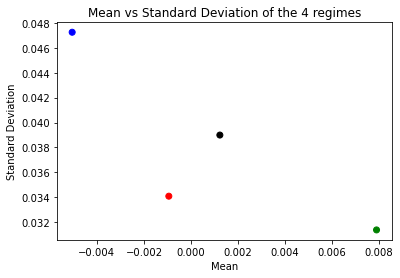

In [7]:
array=[i for i in np.arange(0.01,0.01,0.01)]
for i in range(0,len(arr)):
    
    plt.figure()
#     print("Threshold is:",array[i])
    plt.scatter(arr[i][0],arr[i][1],color=['red','green','blue','black'])
    plt.title('Mean vs Standard Deviation of the 4 regimes')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
plt.show()

In [8]:
print(arr[0][0])
print(arr[0][1])

           Daily
Regime          
0.0    -0.000942
1.0     0.007894
2.0    -0.005054
3.0     0.001229
           Daily
Regime          
0.0     0.034082
1.0     0.031371
2.0     0.047255
3.0     0.038993


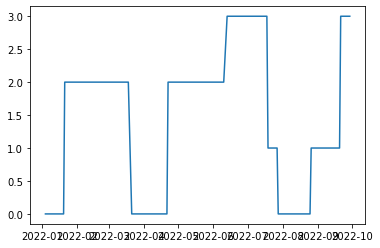

In [9]:
pred=model.predict(X)
dates=df['Date']
df_plot=pd.DataFrame()

df_plot["dates"]=dates
df_plot["pred"]=pred
df_plot.to_excel('/Users/devanshjoshi/Desktop/regimepred.xlsx')
plt.plot(dates,pred)
plt.savefig('/Users/devanshjoshi/Desktop/regimepred.eps', format='eps')
plt.show()
